## Make your own constellation image

I always thought it would be fun to be able to draw an artibrary shape from known star positions. With Gaia, the sky is so dense with known positions, that I thought we do one better: making images on the sky. Here's my attempt.

-Josh Bloom (UC Berkeley, rev Apr 26, 2018)

In [79]:
import io
import os
import logging
import hashlib
import time 
import json 
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Get the data

I downloaded Gaia sources in a limited ra/dec range. You can [get the data](https://berkeley.box.com/s/g4i2qscro7rb6xf1dp3s3n47y42fr0i4) from my Box folder.

In [80]:
df = pd.read_csv("athena/gaia_stars.csv.bz2")

In [81]:
df.head()

source_id          ra        dec           l         b         p  \
0  5344295774288595328  179.006153 -54.632683  294.898806  7.372483  0.959449   
1  5343318858215766272  173.067235 -56.010166  291.974961  5.168184  0.078776   
2  5344258042995784448  179.223171 -54.469424  294.987711  7.558829  0.181689   
3  5343146333650597760  175.879797 -55.865008  293.452016  5.751606  0.313638   
4  6074453713676696064  190.177919 -54.299613  301.349939  8.539186  4.086581   

      bp_rp       pmra     pmdec  
0  1.286824 -13.698911 -5.544605  
1  1.603583  -5.912918  0.760249  
2  1.007000 -10.531308  1.381490  
3  1.272304  -5.217117 -0.218406  
4  1.079248  -1.662249  1.471270

In [5]:
#!conda install holoviews colorcet -y

In [6]:
#!conda install -c conda-forge cartopy -y

In [199]:
#!pip install PyAstronomy

Convert the `ra`, `dec` coordinates to an aitoff project coordinate space:

In [82]:
from PyAstronomy.pyasl import aitoff

x, y, = aitoff(df["ra"].values, df["dec"].values)
df["x"] = -x
df["y"] = y
df["d"] = 1000 / df["p"]  # get the distance in parsecs

Save only those stars in a tight x, y range:

In [83]:
box = {"x": [92.568, 106.894], "y": [-72.052, -70.562]}

new_df = df[ (df["x"] > box["x"][0]) &
    (df["x"] < box["x"][1]) &
    (df["y"] > box["y"][0]) &
    (df["y"] < box["y"][1]) ]

In [84]:
print(len(new_df))

367971



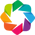

In [85]:
import holoviews as hv
import datashader.transfer_functions as tf
%matplotlib inline
hv.extension('bokeh', 'matplotlib', width="100")

In [86]:
import holoviews as hv
from colorcet import fire, coolwarm, b_diverging_bkr_55_10_c35
from holoviews.operation.datashader import datashade
import geoviews as gv
import geoviews.feature as gf
import datashader as ds

import holoviews.operation.datashader as hd

options = dict(width=610, height=400, xaxis=None, yaxis=None, bgcolor='black')
points = hv.Points(new_df, kdims=['x', 'y'])
rvs = datashade(points, cmap=coolwarm, aggregator=ds.mean('p')).opts(plot=options)

## Let's look at our blank canvas

In [88]:
%%opts QuadMesh [tools=['hover']] (alpha=0 hover_alpha=0.2)
from holoviews.streams import RangeXY

(rvs * hv.util.Dynamic(hd.aggregate(points, width=30, height=30, streams=[RangeXY]), 
                       operation=hv.QuadMesh)).relabel("Gaia blank canvas region")

:DynamicMap   []

Now, let's burn in our image

In [89]:
minx, maxx, miny, maxy = new_df['x'].min(), new_df['x'].max(), new_df['y'].min(), new_df['y'].max()
# minx, maxx, miny, maxy

Now we can scale our image down -- this is trade off: the less we scale down, the more effective pixels we have on sky, but the fewer stars there are in that pixel. That means that the dynamic range of the image will be worse with more pixels.

In [92]:
scale_amount = 2.5

from skimage import io
img = io.imread('imgs/galileo.jpg', as_grey=True)

from skimage.transform import resize
img = resize(img, (img.shape[0] // scale_amount, img.shape[1] // scale_amount))

img = np.flip(img, 0)

#np.min(img), np.max(img)

/Users/jbloom/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


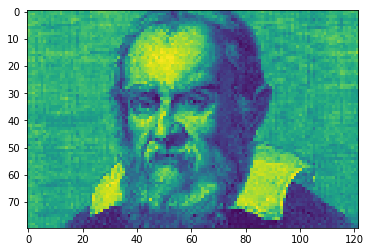

In [93]:
plt.imshow(np.flip(img, 0))

Make a grid to throw our stars within, then sample the number of stars in that "pixel" over `nsample`

In [23]:
x = np.array(np.linspace(minx, maxx, img.shape[1]))
y = np.array(np.linspace(miny, maxy, img.shape[0])) 
XX, YY = np.meshgrid(x, y)

In [26]:
from numpy.random import random_integers
nsample = 30

xsamp = random_integers(0, img.shape[0] - 2, nsample)
ysamp = random_integers(0, img.shape[1] - 2, nsample)

vals = []
for i in range(nsample):
    vals.append(len(
            new_df[
                (new_df["x"] >= XX[xsamp[i]][ysamp[i]]) & (new_df["x"] < XX[xsamp[i] + 1][ysamp[i] + 1]) & \
                (new_df["y"] >= YY[xsamp[i]][ysamp[i]]) & (new_df["y"] < YY[xsamp[i] + 1][ysamp[i] + 1])
            ]
        ))

/Users/jbloom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 78 + 1) instead
  after removing the cwd from sys.path.
/Users/jbloom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 120 + 1) instead
  """


Let's set our brightest "pixel" to be the 10th-percentile of the sampled set

In [95]:
max_stars = np.percentile(vals, [10])[0]  # 10% percentile at top
print(max_stars)  # max stars in pixel

29.9


resample the image at this scaling:

In [28]:
new_img = img - img.min()
new_img = (new_img / new_img.max()*max_stars).astype(np.int16)

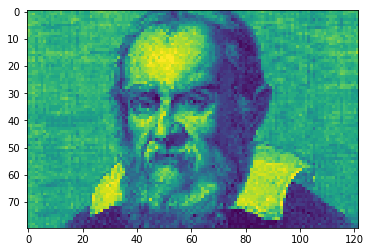

In [96]:
plt.imshow(np.flip(new_img,0))

looks good! Let's make the image!

In [97]:
dfs = []

for i in range(new_img.shape[0] - 1):
    for j in range(new_img.shape[1] - 1):
        tmp_df = \
            new_df[
                (new_df["x"] >= XX[i][j]) & (new_df["x"] < XX[i+1][j+1]) & \
                (new_df["y"] >= YY[i][j]) & (new_df["y"] < YY[i+1][j+1])
            ]
        if len(tmp_df) <= new_img[i][j]:
            dfs.append(tmp_df)
        else:
            dfs.append(tmp_df.sample(new_img[i][j]))

In [98]:
im_df = pd.concat(dfs)

In [77]:
kdims = ["new_x", "new_y"]
ts = [-250,-100,-50,-40,-30,-20,-10,-5,-4,-2,-1,0,1,2,4,5,10,20,50, 100]

def img(t):
    df_filt = im_df.copy()
    df_filt["new_ra"] = im_df["ra"] + (t*im_df["pmra"]/3600.0)*np.cos(im_df["dec"]*np.pi/180.)
    df_filt["new_dec"] = im_df["dec"] + t*im_df["pmdec"]/3600.

    x, y, = aitoff(df_filt["new_ra"].values, df_filt["new_dec"].values)
    df_filt["new_x"] = -x
    df_filt["new_y"] = y
    
    rez = df_filt[(df_filt["new_x"] >= minx) & (df_filt["new_x"] <= maxx) & (df_filt["new_y"] >= miny) & (df_filt["new_y"] <= maxy)]
    
    return rez

plots = {ts[i]: hv.Points(img(ts[i]), kdims) for i in range(len(ts))}


/Users/jbloom/anaconda3/lib/python3.6/site-packages/PyAstronomy/pyasl/asl/aitoffLegacy.py:66: RuntimeWarning: invalid value encountered in greater
  x180 = numpy.where(sa > 180.0)[0]


In [100]:
options = dict(width=610, height=400, xaxis=None, yaxis=None, bgcolor='black')

datashade(hv.HoloMap(plots, kdims='year since 2015.5'), cmap=fire, 
          aggregator=ds.mean('p'), x_sampling=0.003, y_sampling=0.003).opts(plot=options)

:DynamicMap   [year since 2015.5]

This should looke like:
<img src="imgs/gaia_galileo.png">

Scroll around to see how the scene changes around 2015.5 (taking into account the proper motions). This will only work when running in a live notebook. You can also zoom in and watch individual stars

In [103]:
im_df.to_csv("galileo-gaia-constellation.csv")  # save your own personal constellation

This work has made use of data from the European Space Agency (ESA) mission Gaia (https://www.cosmos.esa.int/gaia), processed by the Gaia Data Processing and Analysis Consortium (DPAC, https://www.cosmos.esa.int/web/gaia/dpac/consortium). Funding for the DPAC has been provided by national institutions, in particular the institutions participating in the Gaia Multilateral Agreement.